**About** : This notebook is used to infer models.

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
cd ../src

/home/tviel/work/kaggle_rsna_lumbar_spine/src


In [45]:
# !pip install -qqq /kaggle/input/rsna-abdomen-packages/{pydicom-2.4.3-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.22-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
# !pip install -qqq /kaggle/input/rsna-abdomen-packages/dicomsdl-0.109.2-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
# !pip install -qqq /kaggle/input/contrails-model-def1/einops-0.6.1-py3-none-any.whl
# !pip install -qqq --no-index --find-links /kaggle/input/contrails-wheels/ pretrainedmodels==0.7.4
# !pip install -qqq --no-index --find-links /kaggle/input/contrails-wheels/ efficientnet_pytorch==0.7.1

### Imports

In [46]:
import os
import gc
import re
import sys
import cv2
import glob
import json
import torch
import shutil
import warnings
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [47]:
if os.path.exists("/kaggle/input/rsna-lumbar-spine-code/src"):
    !cp -r /kaggle/input/rsna-lumbar-spine-code/src ./
    sys.path.append("src")

from util.torch import load_model_weights
from util.plots import plot_mask, add_rect
from util.metrics import rsna_loss

from data.processing import process_and_save
from data.transforms import get_transfos
from data.dataset import CropDataset, CoordsDataset
from data.preparation import prepare_data_crop

from inference.seg import get_crops
from inference.dataset import ImageInfDataset, FeatureInfDataset, SafeDataset
from inference.lvl1 import predict, Config

if os.path.exists("/kaggle/input/timm-smp"):
    sys.path.append(
        "/kaggle/input/timm-smp/pytorch-image-models-main/pytorch-image-models-main"
    )
    sys.path.append(
        "/kaggle/input/timm-smp/segmentation_models.pytorch-master/segmentation_models.pytorch-master"
    )
from model_zoo.models import define_model
from model_zoo.models_lvl2 import define_model as define_model_2
from model_zoo.models_seg import define_model as define_model_seg
from model_zoo.models_seg import convert_3d

from params import CLASSES_SEG, MODES, LEVELS_, SEVERITIES, LEVELS

### Params

In [48]:
# !pip install albumentations==1.4.11

In [49]:
EVAL = False
DEBUG = True

ROOT_DATA_DIR = "../input/"
DEBUG_DATA_DIR = "../output/dataset_debug/"  # Todo
SAVE_FOLDER = "../output/tmp/"
shutil.rmtree(SAVE_FOLDER)

# ROOT_DATA_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/"
# DEBUG_DATA_DIR = "/kaggle/input/rsna-2024-debug/"
# SAVE_FOLDER = "/tmp/"

os.makedirs(SAVE_FOLDER, exist_ok=True)
os.makedirs(SAVE_FOLDER + "npy/", exist_ok=True)
os.makedirs(SAVE_FOLDER + "mid/", exist_ok=True)
os.makedirs(SAVE_FOLDER + "csv/", exist_ok=True)

In [50]:
DATA_PATH = ROOT_DATA_DIR + "test_images/"
folds_dict = {}

if DEBUG:
    df_meta = pd.read_csv(ROOT_DATA_DIR + "train_series_descriptions.csv")
else:
    df_meta = pd.read_csv(ROOT_DATA_DIR + "test_series_descriptions.csv")

df_meta["weighting"] = df_meta["series_description"].apply(lambda x: x.split()[1][:2])
df_meta["orient"] = df_meta["series_description"].apply(lambda x: x.split()[0])
df_meta["study_series"] = df_meta["study_id"].astype(str) + "_" + df_meta["series_id"].astype(str)

if DEBUG:
    if EVAL:
        DATA_PATH = ROOT_DATA_DIR + "train_images/"
        FOLDS_FILE = DEBUG_DATA_DIR + "train_folded_v1.csv"
        folds = pd.read_csv(FOLDS_FILE)
        df_meta = df_meta.merge(folds, how="left")
        df_meta = df_meta[df_meta['fold'] == 1].reset_index(drop=True)
    else:
        DATA_PATH = DEBUG_DATA_DIR + "debug_images/"
        df_meta = df_meta.head(3)

        # df_meta_ = df_meta.copy()
        # df_meta_['study_id'] += 1
        # df_meta_ = df_meta_[df_meta_['orient'] == "Axial"]
        # df_meta = pd.concat([df_meta, df_meta_], ignore_index=True)
        # df_meta["study_series"] = df_meta["study_id"].astype(str) + "_" + df_meta["series_id"].astype(str)

In [51]:
BATCH_SIZE = 32
BATCH_SIZE_2 = 512
USE_FP16 = True

NUM_WORKERS = os.cpu_count()

FOLD = 1 if DEBUG else "fullfit_0"
PLOT = DEBUG and not EVAL

In [52]:
EXP_FOLDERS = {
    # "scs": ("../logs/2024-08-04/33/", [FOLD]),
    # "nfn": ("../logs/2024-08-05/27/", [FOLD]),
    # "ss": ("../logs/2024-08-06/17/", [FOLD]),
}

COORDS_FOLDERS = {
    "sag": ("../logs/2024-08-29/0/", FOLD),
    "ax": ("../logs/2024-09-02/33/", FOLD),
}

CROP_EXP_FOLDERS = {
    "crop": ("../logs/2024-08-29/5/", [FOLD], "crops_0.1"),
}

EXP_FOLDERS_2 = [
    # "../logs/2024-09-04/2/",
    "../logs/2024-09-09/2/",
]
FOLDS_2 = [FOLD] if DEBUG else [0, 1, 2, 3]

EXP_FOLDER_3D = "../logs/2024-07-31/25/"

for f in EXP_FOLDERS_2:
    folders = Config(json.load(open(f + "config.json", "r"))).exp_folders
    print("-> Level 2 model:", f)
    for k in folders:
        print(k, folders[k], EXP_FOLDERS.get(k, CROP_EXP_FOLDERS.get(k, ["?"]))[0])
    print()

    
for k in EXP_FOLDERS:
    assert os.path.exists(EXP_FOLDERS[k][0]), f"Model not found: {k}"
for k in CROP_EXP_FOLDERS:
    assert os.path.exists(CROP_EXP_FOLDERS[k][0]), f"Crop model not found: {k}"
for k in COORDS_FOLDERS:
    assert os.path.exists(COORDS_FOLDERS[k][0]), f"Coords model not found: {k}"

-> Level 2 model: ../logs/2024-09-09/2/
dh ../output/oof____cfg_dh_15c.pth ?
ch ../output/oof_cfg_ch_35.pth ?
crop ../logs/2024-08-29/5/ ../logs/2024-08-29/5/



In [53]:
df_meta.head(5)

,study_id,series_id,series_description,weighting,orient,study_series
0,4003253,702807833,Sagittal T2/STIR,T2,Sagittal,4003253_702807833
1,4003253,1054713880,Sagittal T1,T1,Sagittal,4003253_1054713880
2,4003253,2448190387,Axial T2,T2,Axial,4003253_2448190387


In [54]:
# from util.logger import upload_to_kaggle

# folders = [EXP_FOLDERS[k][0] for k in EXP_FOLDERS]
# folders += [CROP_EXP_FOLDERS[k][0] for k in CROP_EXP_FOLDERS]
# folders += [COORDS_FOLDERS[k][0] for k in COORDS_FOLDERS]
# folders += EXP_FOLDERS_2 + [EXP_FOLDER_3D]
# folders = list(set(folders))

# upload_to_kaggle(folders, "../output/dataset_1/", "RSNA 2024 Weights 1")

## Preparation

In [55]:
_ = Parallel(n_jobs=NUM_WORKERS)(
    delayed(process_and_save)(
        df_meta['study_id'][i],
        df_meta['series_id'][i],
        df_meta['orient'][i],
        DATA_PATH,
        save_folder=SAVE_FOLDER,
        save_meta=False,
        save_middle_frame=True,
    ) for i in tqdm(range(len(df_meta)))
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [56]:
# if DEBUG and not EVAL:
#     from data.preparation import prepare_data_crop

#     ref_folder = DEBUG_DATA_DIR + "npy/"
#     # png_ref_folder = "../input/coords/comp_data/"

#     for i in range(len(df_meta)):
#         study_series = df_meta["study_series"][i]
#         npy_ref = np.load(ref_folder + f"{study_series}.npy")
#         npy = np.load(SAVE_FOLDER + f"npy/{study_series}.npy")
#         assert (npy == npy_ref).all()

#         # if df_meta['orient'][i] == "Axial":
#         #     continue

#         # png_ref = cv2.imread(png_ref_folder + f"{study_series}.png")
#         # png = cv2.imread(SAVE_FOLDER + f"mid/{study_series}.png")

#         # # plt.subplot(1, 2, 1)
#         # # plt.imshow(png, cmap="gray")
#         # # plt.subplot(1, 2, 2)
#         # # plt.imshow(png_ref, cmap="gray")
#         # # plt.show()
        
#         # assert (png == png_ref).all()
        

## Sagittal Coords

In [57]:
df_sag = df_meta[df_meta["orient"] == "Sagittal"].reset_index(drop=True)
df_sag = df_sag[df_sag.columns[:6]]

df_sag['img_path'] = SAVE_FOLDER + "mid/" + df_sag["study_series"] + ".png"
df_sag['target'] = [np.ones((5, 2)) for _ in range(len(df_sag))]

df_sag.head(3)

,study_id,series_id,series_description,weighting,orient,study_series,img_path,target
0,4003253,702807833,Sagittal T2/STIR,T2,Sagittal,4003253_702807833,../output/tmp/mid/4003253_702807833.png,"[[1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0..."
1,4003253,1054713880,Sagittal T1,T1,Sagittal,4003253_1054713880,../output/tmp/mid/4003253_1054713880.png,"[[1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0..."


In [58]:
config_sag = Config(json.load(open(COORDS_FOLDERS['sag'][0] + "config.json", "r")))

model_sag = define_model(
    config_sag.name,
    drop_rate=config_sag.drop_rate,
    drop_path_rate=config_sag.drop_path_rate,
    pooling=config_sag.pooling,
    num_classes=config_sag.num_classes,
    num_classes_aux=config_sag.num_classes_aux,
    n_channels=config_sag.n_channels,
    reduce_stride=config_sag.reduce_stride,
    pretrained=False,
)
model_sag = model_sag.cuda().eval()

weights = COORDS_FOLDERS['sag'][0] + f"{config_sag.name}_{COORDS_FOLDERS['sag'][1]}.pt"
model_sag = load_model_weights(model_sag, weights, verbose=1)


 -> Loading encoder weights from ../logs/2024-08-29/0/coatnet_rmlp_2_rw_384_1.pt



In [59]:
%%time
transfos = get_transfos(augment=False, resize=config_sag.resize, use_keypoints=True)
dataset = CoordsDataset(df_sag, transforms=transfos)
dataset = SafeDataset(dataset)

preds_sag, _ = predict(model_sag, dataset, config_sag.loss_config, batch_size=32, use_fp16=True)

CPU times: user 408 ms, sys: 1.02 s, total: 1.43 s
Wall time: 1.53 s


In [60]:
DELTAS = [0.1]  #, 0.15]

for delta in DELTAS:
    os.makedirs(SAVE_FOLDER + f"crops_{delta}", exist_ok=True)

  0%|          | 0/2 [00:00<?, ?it/s]

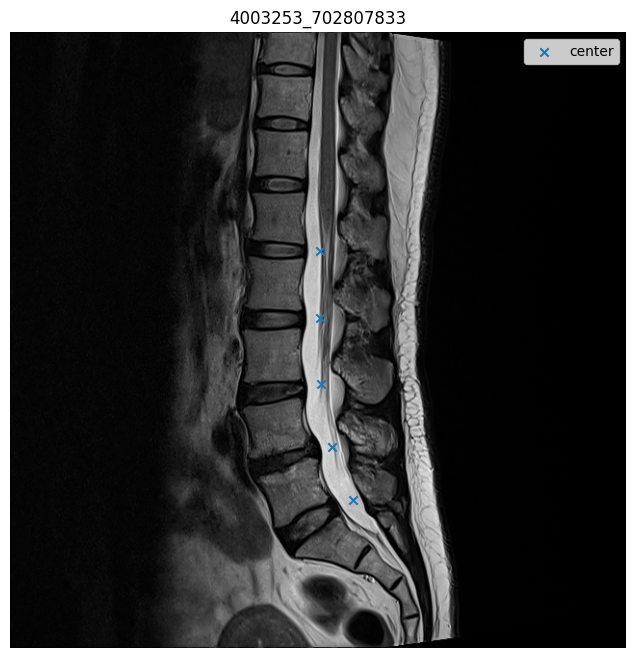

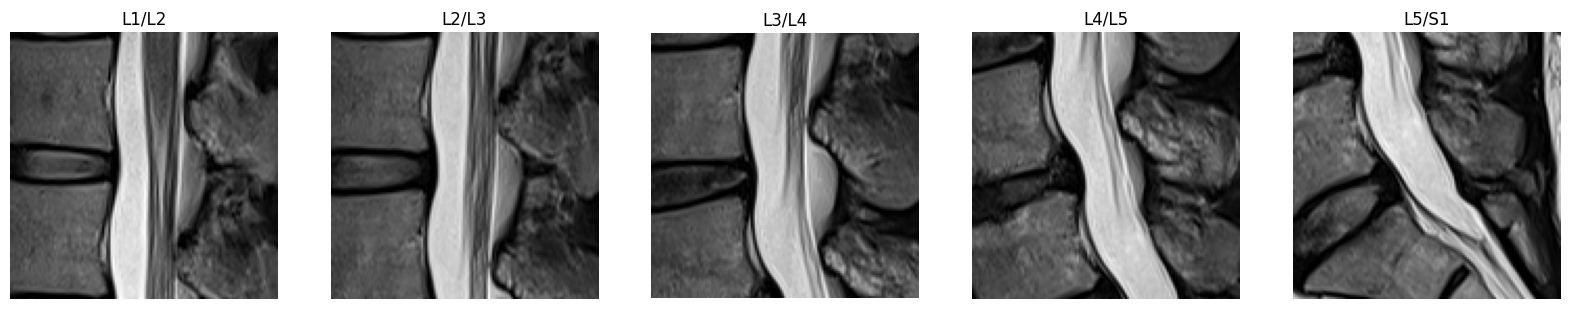

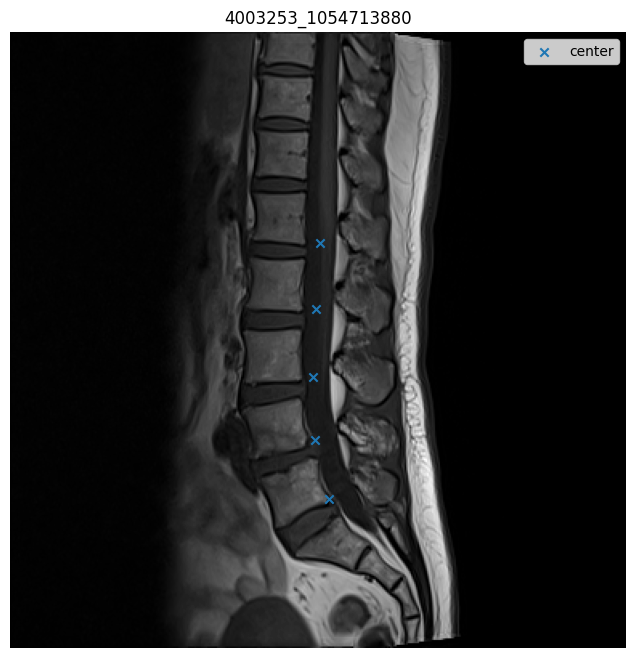

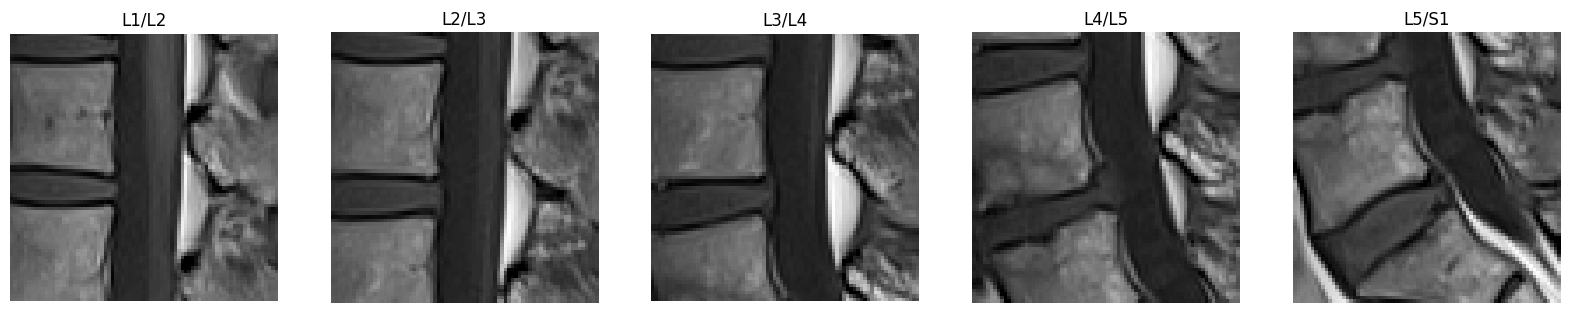

In [61]:
for idx in tqdm(range(len(df_sag))):
    study_series = df_sag["study_series"][idx]
    imgs_path = SAVE_FOLDER + "npy/" + study_series + ".npy"

    imgs = np.load(imgs_path)

    preds = preds_sag[idx].reshape(-1, 2).copy()

    for delta in DELTAS:  # , 0.15
        crops = np.concatenate([preds, preds], -1)
        crops[:, [0, 1]] -= delta
        crops[:, [2, 3]] += delta
        crops = crops.clip(0, 1)

        crops[:, [0, 2]] *= imgs.shape[2]
        crops[:, [1, 3]] *= imgs.shape[1]
        crops = crops.astype(int)

        img_crops = []
        for i, (x0, y0, x1, y1) in enumerate(crops):

            crop = imgs[:, y0: y1, x0: x1].copy()
            # crop = np.zeros((3, 1, 1))
            try:
                assert crop.shape[2] >= 1 and crop.shape[1] >= 1
            except AssertionError:
                # print('!!')
                # pass
                crop = imgs.copy()

            np.save(SAVE_FOLDER + f"crops_{delta}/{study_series}_{LEVELS_[i]}.npy", crop)
            img_crops.append(crop[len(crop) // 2])

        if PLOT:
            preds[:, 0] *= imgs.shape[2]
            preds[:, 1] *= imgs.shape[1]

            plt.figure(figsize=(8, 8))
            plt.imshow(imgs[len(imgs) // 2], cmap="gray")
            plt.scatter(preds[:, 0], preds[:, 1], marker="x", label="center")
            plt.title(study_series)
            plt.axis(False)
            plt.legend()
            plt.show()

            plt.figure(figsize=(20, 4))
            for i in range(5):
                plt.subplot(1, 5, i + 1)
                plt.imshow(img_crops[i], cmap="gray")
                plt.axis(False)
                plt.title(LEVELS[i])
            plt.show()

In [62]:
if DEBUG and not EVAL:
    ref_folder = DEBUG_DATA_DIR + "coords_crops_0.1/"
    df_ref = prepare_data_crop(ROOT_DATA_DIR, ref_folder).head(10)

    df_ref['img_path_2'] = df_ref['img_path'].apply(
        lambda x: re.sub(ref_folder, SAVE_FOLDER + f"crops_0.1/", x)
    )

    for i in range(len(df_ref)):
        cref = np.load(df_ref['img_path'][i])
        c = np.load(df_ref['img_path_2'][i])
        assert (cref == c).all()
        # plt.subplot(1, 2, 1)
        # plt.imshow(c[len(c) // 2], cmap="gray")
        # plt.subplot(1, 2, 2)
        # plt.imshow(cref[len(cref) // 2], cmap="gray")
        # plt.show()
        # break

## Axial Coords
- Not used yet

## Seg & Level 1
- Not used currently

In [63]:
# config_seg = Config(json.load(open(EXP_FOLDER_3D + "config.json", "r")))

# model_seg = define_model_seg(
#     config_seg.decoder_name,
#     config_seg.name,
#     num_classes=config_seg.num_classes,
#     num_classes_aux=config_seg.num_classes_aux,
#     increase_stride=config_seg.increase_stride,
#     use_cls=config_seg.use_cls,
#     n_channels=config_seg.n_channels,
#     use_3d=config_seg.use_3d,
#     pretrained=False,
# )

# model_seg = load_model_weights(
#     model_seg, EXP_FOLDER_3D + f"{config_seg.name}_{FOLD}.pt"
# )
# model_seg = model_seg.cuda()
# # model_seg = model_seg.eval()  # Hurts results ??

In [64]:
# models = {}
# for mode in EXP_FOLDERS:
#     exp_folder, folds = EXP_FOLDERS[mode]
#     print(f"- Mode: {mode}")
#     config = Config(json.load(open(exp_folder + "config.json", "r")))

#     models_ = []
#     for fold in folds:
#         model = define_model(
#             config.name,
#             drop_rate=config.drop_rate,
#             drop_path_rate=config.drop_path_rate,
#             use_gem=config.use_gem,
#             num_classes=config.num_classes,
#             num_classes_aux=config.num_classes_aux,
#             n_channels=config.n_channels,
#             reduce_stride=config.reduce_stride,
#             increase_stride=(
#                 config.increase_stride if hasattr(config, "increase_stride") else False
#             ),
#             pretrained=False,
#         )
#         model = model.cuda().eval()

#         weights = exp_folder + f"{config.name}_{fold}.pt"
#         model = load_model_weights(model, weights, verbose=config.local_rank == 0)
#         models_.append(model)

#     models[mode] = models_

In [65]:
# dfs = []
# for study in tqdm(sorted(os.listdir(DATA_PATH))):
#     if folds_dict.get(int(study), 0) != FOLD and EVAL:
#         continue

#     for series in sorted(os.listdir(DATA_PATH + study)):
#         print("\n-> study", study, "- Series", series)

#         imgs, orient, weighting = process(
#             study,
#             series,
#             data_path=DATA_PATH,
#             on_gpu=False,
#         )

#         try:
#             weighting, orient = df_meta.loc[(int(study), int(series))].values[1:]
#             # print(orient, weighting)
#         except:
#             pass

#         dfs.append(
#             {
#                 "study_id": study,
#                 "series_id": series,
#                 "orient": orient,
#                 "weighting": weighting,
#             }
#         )

#         print(f"- Orient {orient} - Weighting {weighting}")

#         # Segmentation
#         if orient == "Sagittal":
#             x = imgs[:, ::-1].copy().astype(np.float32)

#             with torch.inference_mode():
#                 x = torch.from_numpy(x).cuda()
#                 x = F.interpolate(
#                     x.unsqueeze(0).unsqueeze(0),
#                     config_seg.img_size,
#                     mode="trilinear",
#                 )
#                 x = (x - x.min()) / (x.max() - x.min())

#                 mask, _ = model_seg(x)
#                 mask = F.interpolate(
#                     mask,
#                     imgs.shape,
#                     mode="trilinear",
#                 )[
#                     0
#                 ].argmax(0)
#             mask = mask.cpu().numpy()[:, ::-1].astype(np.uint8)

#             if DEBUG and PLOT:
#                 img_ref = np.load(DEBUG_DATA_DIR + f"npy/{study}_{series}.npy")
#                 mask_ref = np.load(DEBUG_DATA_DIR + f"train_segs/{study}_{series}.npy")
#                 delta = (np.abs(mask - mask_ref) > 0).mean()
#                 print("Mask delta:", delta)
#                 delta = (np.abs(imgs - img_ref) > 0).mean()
#                 print("Img delta:", delta)

#             if PLOT:
#                 f = len(imgs) // 2
#                 plt.figure(figsize=(4, 4))
#                 plot_mask(imgs[f], mask[f])
#                 plt.show()

#             # Cropping
#             disk_crops = {}
#             for disk in CLASSES_SEG[5:]:
#                 x0, x1, y0, y1, z0, z1 = get_crops(mask, disk=disk)
#                 disk_crops[disk] = (x0, x1, y0, y1, z0, z1)

#                 img_crop = imgs[x0:x1, y0:y1, z0:z1]
#                 # mask_crop = mask[x0: x1, y0:y1, z0:z1]

#                 d = re.sub("/", "_", disk.lower())
#                 np.save(SAVE_FOLDER + f"{study}_{series}_{d}.npy", img_crop.copy())

#             if PLOT:
#                 plt.figure(figsize=(8, 8))
#                 plot_mask(imgs[f], mask[f])

#                 for d, disk in enumerate(disk_crops):
#                     x0, x1, y0, y1, z0, z1 = disk_crops[disk]
#                     add_rect(x0, x1, y0, y1, z0, z1, f, col="skyblue")
#                     plt.text(
#                         10,
#                         (d + 1) * 20,
#                         f"{disk} disk center frame: {int((x1 + x0) / 2)}",
#                         color="skyblue",
#                     )
#                 plt.show()

#         # Cls
#         mode = MODES[weighting + "_" + orient]
#         exp_folder, models_list = EXP_FOLDERS[mode][0], models[mode]

#         config = Config(json.load(open(exp_folder + "config.json", "r")))

#         imgs = (imgs - imgs.min()) / (imgs.max() - imgs.min()) * 255
#         imgs = imgs.astype(np.uint8)

#         transforms = get_transfos(augment=False, resize=config.resize, crop=config.crop)
#         dataset = ImageInfDataset(
#             imgs,
#             transforms=transforms,
#             frames_chanel=(
#                 config.frames_chanel if hasattr(config, "frames_chanel") else 0
#             ),
#             n_frames=config.n_frames if hasattr(config, "n_frames") else 1,
#             stride=config.stride if hasattr(config, "stride") else 1,
#         )

#         preds = []
#         for model in models_list:
#             pred, pred_aux = predict(
#                 model,
#                 dataset,
#                 config.loss_config,
#                 batch_size=BATCH_SIZE,
#                 use_fp16=USE_FP16,
#                 num_workers=NUM_WORKERS,
#             )
#             preds.append(pred)
#         preds = np.mean(preds, 0)

#         if PLOT:
#             plt.figure(figsize=(8, 5))
#             plt.plot(preds[:, :, 0])
#             plt.show()

#         np.save(SAVE_FOLDER + f"{study}_{series}_{mode}.npy", preds)

# del model_seg, models, imgs, x, mask, dataset
# torch.cuda.empty_cache()
# gc.collect()

In [66]:
# if DEBUG and not EVAL:
#     for study in sorted(os.listdir(DATA_PATH)):
#         for series in sorted(os.listdir(DATA_PATH + study)):
#             print("-> study", study, "- Series", series)
#             for mode in EXP_FOLDERS:
#                 exp_folder, folds = EXP_FOLDERS[mode]
#                 try:
#                     preds_ref = np.load(exp_folder + f"preds/{study}_{series}.npy")
#                 except:
#                     continue

#                 preds = np.load(SAVE_FOLDER + f"{study}_{series}_{mode}.npy")

#                 assert preds.shape == preds_ref.shape

#                 delta = ((preds - preds_ref) ** 2).max()
#                 print(f"{mode} delta :", delta)

In [67]:
# if DEBUG and not EVAL:
#     df["img_path_ref"] = DEBUG_DATA_DIR + "crops_fix/"
#     df["img_path_ref"] += (
#         df["study_id"] + "_" + df["series_id"] + "_" + df["level"] + ".npy"
#     )
#     for i in range(len(df)):
#         path_ref = df["img_path_ref"][i]
#         path = df["img_path"][i]

#         if os.path.exists(path_ref):
#             crop_ref = np.load(path_ref)
#             crop = np.load(path)

#             print(
#                 f"Crop {path.split('/')[-1][:-4]} delta:\t",
#                 ((crop_ref - crop) ** 2).max(),
#             )

## Crop models

In [68]:
df = df_meta.copy()

df["target"] = 0
df["coords"] = 0

df["level"] = [LEVELS for _ in range(len(df))]
df["level_"] = [LEVELS_ for _ in range(len(df))]
df = df.explode(["level", "level_"]).reset_index(drop=True)
df["img_path_"] = df["study_series"] + "_" + df["level_"] + ".npy"

In [69]:
crop_fts = {}
for mode in tqdm(CROP_EXP_FOLDERS, total=len(CROP_EXP_FOLDERS)):
    exp_folder, folds, crop_folder = CROP_EXP_FOLDERS[mode]
    print(f"- Model {mode} - {exp_folder}")

    config = Config(json.load(open(exp_folder + "config.json", "r")))

    if mode == "crop":
        df_mode = df[df['orient'] == "Sagittal"].reset_index(drop=True)
        df_mode["side"] = "Center"
    elif "scs" in mode:
        df_mode = df[df['orient'] == "Sagittal"]
        df_mode = df_mode[df_mode["weighting"] == "T2"].reset_index(drop=True)
        df_mode["side"] = "Center"
    elif "nfn" in mode:
        df_mode = df[df['orient'] == "Sagittal"]
        df_mode["side"] = ["Right", "Left"]
        df_mode = df_mode.explode("side").reset_index(drop=True)
        df_mode = df_mode.sort_values(
            ["study_id", "series_id", "side", "level"],
            ascending=[True, True, False, True],
            ignore_index=True
        )
    elif "ss" in mode:
        df_mode = df[df['orient'] == "Axial"]
        df_mode["side"] = ["Right", "Left"]
        df_mode = df_mode.explode("side").reset_index(drop=True)
        df_mode = df_mode.sort_values(
            ["study_id", "series_id", "side", "level"],
            ascending=[True, True, False, True],
            ignore_index=True
        )

    df_mode['img_path'] = SAVE_FOLDER + crop_folder + "/" + df_mode["img_path_"]

    transfos = get_transfos(augment=False, resize=config.resize, crop=config.crop)
    dataset = CropDataset(
        df_mode,
        targets="target",
        transforms=transfos,
        frames_chanel=config.frames_chanel,
        n_frames=config.n_frames,
        stride=config.stride,
        train=False,
        load_in_ram=False,
    )
    dataset = SafeDataset(dataset)

    model = define_model(
        config.name,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        pooling=config.pooling,
        head_3d=config.head_3d,
        n_frames=config.n_frames,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        reduce_stride=config.reduce_stride,
        pretrained=False,
    )
    model = model.cuda().eval()

    preds = []
    for fold in folds:
        weights = exp_folder + f"{config.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=1)

        pred, _ = predict(
            model,
            dataset,
            config.loss_config,
            batch_size=BATCH_SIZE,
            use_fp16=USE_FP16,
            num_workers=NUM_WORKERS,
        )
        preds.append(pred)

    preds = np.mean(preds, 0)

    if PLOT:
        df_ref = pd.read_csv(exp_folder + f"df_val_{FOLD}.csv").head(len(preds))
        # order_ref = df_ref.sort_values(["side", "level"]).index.values
        preds_ref = np.load(exp_folder + f"pred_inf_{FOLD}.npy")[: len(preds)]  # [order_ref]

        # plt.figure(figsize=(8, 4))
        # plt.subplot(1, 2, 1)
        # plt.plot(preds)
        # plt.subplot(1, 2, 2)
        # plt.plot(preds_ref)
        # plt.show()

        delta = (np.abs(preds - preds_ref)).max()
        print(preds.shape, preds_ref.shape)
        print(f"{mode} delta:", delta)

    idx = df_mode[["study_id", "series_id", "level", "side"]].values.astype(str).tolist()
    idx = ["_".join(i) for i in idx]
    crop_fts[mode] = dict(zip(idx, preds))

  0%|          | 0/1 [00:00<?, ?it/s]

- Model crop - ../logs/2024-08-29/5/

 -> Loading encoder weights from ../logs/2024-08-29/5/coatnet_1_rw_224_1.pt

(10, 5, 3) (10, 5, 3)
crop delta: 0.003906


## Level 2

In [70]:
def sub_to_dict(file):
    sub = pd.read_csv(file)
    sub['study'] = sub['row_id'].apply(lambda x: x.split('_')[0])
    sub['tgt'] = sub['row_id'].apply(lambda x: x.split('_', 1)[-1])

    cols = [
        "spinal_canal_stenosis_l1_l2",
        "spinal_canal_stenosis_l2_l3",
        "spinal_canal_stenosis_l3_l4",
        "spinal_canal_stenosis_l4_l5",
        "spinal_canal_stenosis_l5_s1",
        "left_neural_foraminal_narrowing_l1_l2",
        "left_neural_foraminal_narrowing_l2_l3",
        "left_neural_foraminal_narrowing_l3_l4",
        "left_neural_foraminal_narrowing_l4_l5",
        "left_neural_foraminal_narrowing_l5_s1",
        "right_neural_foraminal_narrowing_l1_l2",
        "right_neural_foraminal_narrowing_l2_l3",
        "right_neural_foraminal_narrowing_l3_l4",
        "right_neural_foraminal_narrowing_l4_l5",
        "right_neural_foraminal_narrowing_l5_s1",
        "left_subarticular_stenosis_l1_l2",
        "left_subarticular_stenosis_l2_l3",
        "left_subarticular_stenosis_l3_l4",
        "left_subarticular_stenosis_l4_l5",
        "left_subarticular_stenosis_l5_s1",
        "right_subarticular_stenosis_l1_l2",
        "right_subarticular_stenosis_l2_l3",
        "right_subarticular_stenosis_l3_l4",
        "right_subarticular_stenosis_l4_l5",
        "right_subarticular_stenosis_l5_s1",
    ]

    preds_dict = {}
    for study, dfs in sub.groupby('study'):
        # display(dfs)
        dfs = dfs[["tgt", "normal_mild", "moderate", "severe"]].set_index("tgt")
        preds = np.zeros((25, 3))
        for i, c in enumerate(cols):
            preds[i] = dfs.loc[c].values
        preds_dict[study] = preds
    return preds_dict

In [71]:
# csv_fts = {
#     "ch": sub_to_dict("submission.csv"),
#     "dh": sub_to_dict("submission.csv"),
# }

csv_fts = {
    "ch": sub_to_dict("submission.csv"),
    "dh": sub_to_dict("submission.csv"),
}

In [72]:
csv_fts = {}
for k in ['ch', 'dh']:
    # config_2.exp_folders['dh'], config_2.exp_folders['ch']
    file = torch.load(config_2.exp_folders[k])
    csv_fts[k] = dict(zip(
        file["study_id"].tolist(),
        file['logits'].float().cpu().numpy(),
    ))


In [74]:
df_2 = df_meta[
    ["study_id", "series_id", "series_description"]
].groupby('study_id').agg(list).reset_index()

all_preds = []
for exp_folder in EXP_FOLDERS_2:
    config_2 = Config(json.load(open(exp_folder + "config.json", "r")))

    csv_fts = {}
    for k in config_2.exp_folders:
        if "ch" in k or "dh" in k:
            file = torch.load(config_2.exp_folders[k])
            csv_fts[k] = dict(zip(
                file["study_id"].tolist(),
                file['logits'].float().cpu().numpy(),
            ))


    dataset = FeatureInfDataset(
        df_2,
        config_2.exp_folders,
        crop_fts,
        csv_fts,
        save_folder=SAVE_FOLDER,
    )
    # dataset = SafeDataset(dataset)

    model = define_model_2(
        config_2.name,
        ft_dim=config_2.ft_dim,
        layer_dim=config_2.layer_dim,
        dense_dim=config_2.dense_dim,
        p=config_2.p,
        n_fts=config_2.n_fts,
        resize=config_2.resize,
        num_classes=config_2.num_classes,
        num_classes_aux=config_2.num_classes_aux,
    )
    model = model.eval().cuda()

    for fold in FOLDS_2:
        weights = exp_folder + f"{config_2.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=config.local_rank == 0)

        preds, _ = predict(
            model,
            dataset,
            config_2.loss_config,
            batch_size=BATCH_SIZE_2,
            use_fp16=USE_FP16,
            num_workers=NUM_WORKERS,
        )

        if DEBUG and not EVAL:
            preds_ref = np.load(EXP_FOLDERS_2[0] + f"pred_val_{fold}.npy")[:1]
            delta = np.abs(preds - preds_ref).max()
            print(f"Model {exp_folder} delta:", delta)

        all_preds.append(preds)


 -> Loading encoder weights from ../logs/2024-09-09/2/simple_1.pt

Model ../logs/2024-09-09/2/ delta: 0.00013655424


In [76]:
preds = np.mean(all_preds, 0).astype(np.float64)
studies = df_2[["study_id"]].copy().astype(int)

rows = []
for i in range(len(studies)):
    for c, injury in enumerate(config_2.targets):
        rows.append(
            {
                "row_id": f'{studies["study_id"].values[i]}_{injury}',
                "normal_mild": preds[i, c, 0],
                "moderate": preds[i, c, 1],
                "severe": preds[i, c, 2],
            }
        )

sub = pd.DataFrame(rows)
sub.to_csv("submission.csv", index=False)
sub.tail(25)

,row_id,normal_mild,moderate,severe
0,4003253_spinal_canal_stenosis_l1_l2,0.999214,0.000664,0.000122
1,4003253_spinal_canal_stenosis_l2_l3,0.998890,0.000949,0.000160
2,4003253_spinal_canal_stenosis_l3_l4,0.996065,0.003544,0.000391
3,4003253_spinal_canal_stenosis_l4_l5,0.978683,0.019325,0.001992
4,4003253_spinal_canal_stenosis_l5_s1,0.997790,0.001824,0.000386
5,4003253_left_neural_foraminal_narrowing_l1_l2,0.997577,0.002408,0.000015
6,4003253_left_neural_foraminal_narrowing_l2_l3,0.997140,0.002842,0.000018
7,4003253_left_neural_foraminal_narrowing_l3_l4,0.988160,0.011743,0.000098
8,4003253_left_neural_foraminal_narrowing_l4_l5,0.563150,0.425088,0.011762
9,4003253_left_neural_foraminal_narrowing_l5_s1,0.841841,0.154362,0.003797


In [77]:
if EVAL:
    y = pd.read_csv(ROOT_DATA_DIR + "train.csv")

    for c in y.columns[1:]:
        y[c] = y[c].map(dict(zip(SEVERITIES, [0, 1, 2]))).fillna(-1)
    y = y.astype(int)

    df_val = studies.copy().merge(y, how="left")

    avg_loss, losses = rsna_loss(df_val[config_2.targets].values, preds)

    for k, v in losses.items():
        print(f"- {k}_loss\t: {v:.3f}")

    print(f"\n -> CV Score : {avg_loss :.3f}")

Done ! 